사용 중인 디바이스: cuda


Training Episodes: 100%|██████████████| 10000/10000 [13:32:21<00:00,  4.87s/it, Total Reward=-150150.00, Epsilon=0.607]


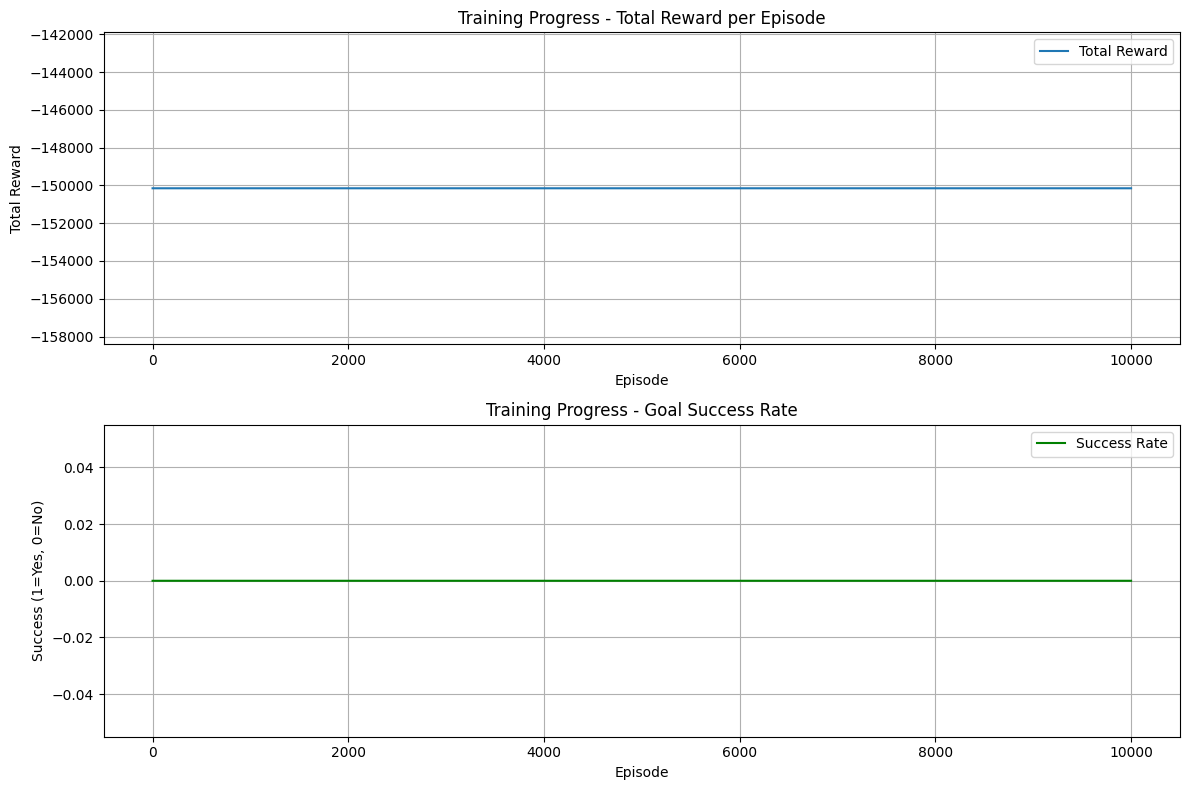

학습 완료! 모델이 'tidal_navigation_model.pth'로 저장되었습니다.


In [10]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from datetime import datetime, timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt

# 하이퍼파라미터 정의
GRID_SIZE = (810, 710)  # 위도(810), 경도(710)
LAT_RANGE = (30.0, 38.0)  # 위도 범위
LON_RANGE = (120.0, 127.0)  # 경도 범위
START_POS = (37.46035, 126.62360)  # 인천항
GOAL_POS = (30.62828, 122.06400)   # 상하이항
EPISODES = 10000  # 학습 에피소드 수
BATCH_SIZE = 128  # 배치 크기
GAMMA = 0.99  # 할인율
EPSILON_START = 1.0  # 초기 탐험 확률
EPSILON_END = 0.01  # 최종 탐험 확률
EPSILON_DECAY = 0.99995  # 탐험 확률 감소율
LEARNING_RATE = 0.00005  # 학습률
MAX_STEPS = 1500  # 최대 스텝 수
ACTION_SIZE = 8  # 8방향 이동
TIDAL_BASE_PATH = r"C:\baramproject\tidal_database"  # JSON 파일 경로

# CUDA 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}")

# 유틸리티 함수
def latlon_to_grid(lat, lon):
    """위도/경도를 그리드 좌표로 변환"""
    lat_min, lat_max = LAT_RANGE
    lon_min, lon_max = LON_RANGE
    x = int((lat - lat_min) / (lat_max - lat_min) * (GRID_SIZE[0] - 1))
    y = int((lon - lon_min) / (lon_max - lon_min) * (GRID_SIZE[1] - 1))  # 수정: lon_min으로 변경
    return max(0, min(x, GRID_SIZE[0] - 1)), max(0, min(y, GRID_SIZE[1] - 1))

def grid_to_latlon(x, y):
    """그리드 좌표를 위도/경도로 변환"""
    lat_min, lat_max = LAT_RANGE
    lon_min, lon_max = LON_RANGE
    lat = lat_min + (x / (GRID_SIZE[0] - 1)) * (lat_max - lat_min)
    lon = lon_min + (y / (GRID_SIZE[1] - 1)) * (lon_max - lon_min)
    return lat, lon

# 환경 클래스
class TidalNavigationEnv:
    def __init__(self):
        self.grid_size = GRID_SIZE
        self.start_pos = latlon_to_grid(*START_POS)
        self.goal_pos = latlon_to_grid(*GOAL_POS)
        self.current_pos = self.start_pos
        self.start_date = datetime(2018, 1, 1, 0, 0)
        self.end_date = datetime(2018, 12, 28, 0, 0)
        self.current_time = None  # 출항 시간을 매 에피소드마다 설정
        self.tidal_data = None
        self.step_count = 0
        self.prev_action = None
        self.actions = [(0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1)]  # 8방향
        # 육지/해양 맵 파일 로드
        self.land_mask = np.load(r"C:\baramproject\tidal_database\land_mask_810x710.npy")

    def load_tidal_data(self, time):
        """JSON 파일에서 조류 데이터 로드"""
        if time > self.end_date:
            time = self.end_date
        time_str = time.strftime("%Y%m%d_%H%M")
        file_path = f"{TIDAL_BASE_PATH}/tidal_{time_str}.json"
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            return data['result']['data']
        except FileNotFoundError:
            print(f"파일을 찾을 수 없습니다: {file_path}")
            return []

    def reset(self):
        """환경 초기화: 출항 시간을 30분 단위로 무작위 설정"""
        total_half_hours = int((self.end_date - self.start_date).total_seconds() / 1800)  # 1800초 = 30분
        random_half_hour = random.randint(0, total_half_hours)
        self.current_time = self.start_date + timedelta(minutes=30 * random_half_hour)
        self.current_pos = self.start_pos
        self.step_count = 0
        self.tidal_data = self.load_tidal_data(self.current_time)
        state = self.get_state()
        return state

    def get_state(self):
        """상태 반환: [현재 위치(x, y), 목표 위치(x_goal, y_goal), 조류 방향, 조류 속도, 시간]"""
        tidal_dir, tidal_speed = self.get_tidal_effect(self.current_pos)
        return np.array([self.current_pos[0] / GRID_SIZE[0], self.current_pos[1] / GRID_SIZE[1],
                         self.goal_pos[0] / GRID_SIZE[0], self.goal_pos[1] / GRID_SIZE[1],
                         tidal_dir / 360.0, tidal_speed / 100.0, self.step_count / MAX_STEPS], dtype=np.float32)

    def get_tidal_effect(self, pos):
        """현재 위치에 가장 가까운 조류 데이터 반환"""
        lat, lon = grid_to_latlon(pos[0], pos[1])
        min_dist = float('inf')
        tidal_dir, tidal_speed = 0, 0
        for entry in self.tidal_data:
            entry_lat = float(entry['pre_lat'])
            entry_lon = float(entry['pre_lon'])
            dist = (lat - entry_lat) ** 2 + (lon - entry_lon) ** 2
            if dist < min_dist:
                min_dist = dist
                tidal_dir = float(entry['current_dir'])
                tidal_speed = float(entry['current_speed'])
        return tidal_dir, tidal_speed

    def step(self, action):
        """선박 이동 및 보상 계산"""
        dx, dy = self.actions[action]
        next_pos = (self.current_pos[0] + dx, self.current_pos[1] + dy)
        self.step_count += 1

        # 10스텝마다 시간 업데이트 및 조류 데이터 갱신 (30분 단위로 고정)
        if self.step_count % 10 == 0:
            self.current_time += timedelta(minutes=30)
            minutes_since_start = (self.current_time - self.start_date).total_seconds() / 60
            adjusted_minutes = 30 * round(minutes_since_start / 30)
            self.current_time = self.start_date + timedelta(minutes=adjusted_minutes)
            self.tidal_data = self.load_tidal_data(self.current_time)

        reward = self.calculate_reward(next_pos, action)
        done = (next_pos == self.goal_pos) or (self.step_count >= MAX_STEPS)
        if (0 <= next_pos[0] < self.grid_size[0] and 0 <= next_pos[1] < self.grid_size[1] and 
            not self.land_mask[next_pos]):
            self.current_pos = next_pos
        else:
            reward -= 50  # 경계 밖 또는 육지 페널티
        self.prev_action = action
        return self.get_state(), reward, done, {}

    def calculate_reward(self, next_pos, action):
        """보상 계산"""
        reward = -0.1  # 기본 시간 패널티
        if next_pos == self.goal_pos:
            reward += 100  # 목표 도달 보상
        elif not (0 <= next_pos[0] < self.grid_size[0] and 0 <= next_pos[1] < self.grid_size[1]) or self.land_mask[next_pos]:
            reward -= 50  # 경계 밖 또는 육지 페널티
        else:
            # 방향 전환 최소화
            if self.prev_action is not None:
                angle_diff = abs(action - self.prev_action) * 45
                angle_diff = min(angle_diff, 360 - angle_diff)
                if angle_diff > 45:
                    reward -= 2  # 큰 방향 전환 패널티

            # 조류와의 일치/불일치 보상/패널티
            tidal_dir, tidal_speed = self.get_tidal_effect(next_pos)
            ship_dir = action * 45
            angle_diff = abs(tidal_dir - ship_dir)
            if angle_diff > 180:
                angle_diff = 360 - angle_diff
            if angle_diff < 45:  # 조류와 방향이 비슷한 경우 (45도 이내)
                reward += tidal_speed / 100.0  # 유속 비례 양의 보상
            else:
                reward -= tidal_speed / 100.0  # 유속 비례 음의 보상 (패널티)

        return reward

# Dueling DQN 모델
class DuelingDQN(nn.Module):
    def __init__(self, state_size=7, action_size=ACTION_SIZE):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.value_stream = nn.Linear(512, 1)
        self.advantage_stream = nn.Linear(512, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.value_stream(x)
        advantages = self.advantage_stream(x)
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values

# 학습 함수
def train_dqn():
    env = TidalNavigationEnv()
    model = DuelingDQN().to(device)
    target_model = DuelingDQN().to(device)
    target_model.load_state_dict(model.state_dict())
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    replay_buffer = deque(maxlen=10000)
    epsilon = EPSILON_START

    # 진행률 및 리워드 추적
    total_rewards = []
    success_rates = []

    with tqdm(range(EPISODES), desc="Training Episodes") as pbar:
        for episode in pbar:
            # 출항 시간 무작위 설정 (2018.01.01 00:00 ~ 2018.12.28 00:00)
            start_days = (datetime(2018, 12, 28) - datetime(2018, 1, 1)).days + 1
            random_days = random.randint(0, start_days - 1)
            start_time = datetime(2018, 1, 1) + timedelta(days=random_days)
            env.current_time = start_time.replace(hour=0, minute=0)
            env.tidal_data = env.load_tidal_data(env.current_time)

            state = env.reset()
            done = False
            total_reward = 0
            success = 0  # 목표 도달 여부 (1=도달, 0=미도달)
            while not done:
                if random.random() < epsilon:
                    action = random.randint(0, ACTION_SIZE - 1)
                else:
                    with torch.no_grad():
                        q_values = model(torch.tensor(np.array(state), dtype=torch.float32).unsqueeze(0).to(device))
                        action = q_values.argmax().item()

                next_state, reward, done, _ = env.step(action)
                replay_buffer.append((state, action, reward, next_state, done))
                state = next_state
                total_reward += reward

                if next_state[2] * GRID_SIZE[0] == env.goal_pos[0] and next_state[3] * GRID_SIZE[1] == env.goal_pos[1]:
                    success = 1

                if len(replay_buffer) >= BATCH_SIZE:
                    batch = random.sample(replay_buffer, BATCH_SIZE)
                    states, actions, rewards, next_states, dones = zip(*batch)
                    states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
                    actions = torch.tensor(actions, dtype=torch.long).to(device)
                    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
                    next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
                    dones = torch.tensor(dones, dtype=torch.float32).to(device)

                    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                    next_q_values = target_model(next_states).max(1)[0]
                    targets = rewards + GAMMA * next_q_values * (1 - dones)
                    loss = nn.MSELoss()(q_values, targets.detach())
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                if done:
                    pbar.set_postfix({"Total Reward": f"{total_reward:.2f}", "Epsilon": f"{epsilon:.3f}"})

            total_rewards.append(total_reward)
            success_rates.append(success)

            epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
            if episode % 10 == 0:
                target_model.load_state_dict(model.state_dict())

    # 학습 진행 그래프 시각화
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_rewards, label="Total Reward")
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress - Total Reward per Episode')
    plt.grid(True)
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(success_rates, label="Success Rate", color='green')
    plt.xlabel('Episode')
    plt.ylabel('Success (1=Yes, 0=No)')
    plt.title('Training Progress - Goal Success Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    torch.save(model.state_dict(), r"C:\baramproject\trained_model\sibaal\tidal_navigation_model.pth")
    print("학습 완료! 모델이 'tidal_navigation_model.pth'로 저장되었습니다.")

if __name__ == "__main__":
    train_dqn()